#Python Implementation of ACO for Path Planning

This is a python implementation of the Ant Colony Optimization algorithm for the Sorthest Path and Travelling Salesman Problem

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Proyectos/ACO/

/content/gdrive/MyDrive/Proyectos/ACO


In [1]:
# import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import enum
import numpy as np
import random
import os
import pandas as pd
from collections import Counter

In [2]:
DATA_DIR = "stuff/data/"
SAVING_DIR = "stuff/results/proximities/sampling"

# Ant Colony Optimizer

First, we did a little review of the algorithm that we are using. The algorithm is based on **Ant Colony System** with some additional functions, found here
[Ant Colony Optimization: Artificial Ants as a Computational Intelligence Technique](https://ieeexplore.ieee.org/abstract/document/4129846)

## Ant Colony System
This is an interative algorithm. In each iteration, 

1. A number of ants find differents solutions. To do that, each ant follows a `pseudorandom  proportional rule`. Thus, the probability for an ant to move from city $i$ to city $j$ depends on a random variable $q$ uniformly distributed over $[0,1]$, and a parameter $q_0$. Therefore, if $q \le q_0$, then $j=\arg \max _{c_{i l} \in N(s p)}\left\{\tau_{i l} \eta_{i l}^{\beta}\right\}$, otherwise use the next equation

$$ p_{i j}^{k}=\left\{\begin{array}{ll}
\frac{\tau_{i j}^{\alpha} \cdot \eta_{i j}^{\beta}}{\sum_{c_{i l} \in \mathrm{N}\left(s^{p}\right)} \tau_{i l}^{\alpha} \cdot \eta_{i l}^{\beta}} & \text { if } c_{i j} \in \mathbf{N}\left(s^{p}\right) \\
0 & \text { otherwise }
\end{array}\right. $$

where $\mathrm{N}(s^p)$ is the set of feasible neighbors components; edges $(i,l)$ where $l$ is a city not yet visited by ant $k$. The parameters $\alpha$ and $\beta$ control the relative importance of the pheromone versus the heurisitc information $\eta_{ij}$


2. A `local pheromone evaporation` is performed by all the ants after each construction step. Each ant applies it only to the last edge traversed:

$$ \tau_{i j}=(1-\varphi) \cdot \tau_{i j}+\varphi \cdot \tau_{0} $$

where $\varphi \in (0,1]$ is the pheromone decay coefficient, and $\tau_{0}$ the initial value pheromone. 

Note: the main goal of `local pheromone evaporation` is to diversify  the search performed by subsequent ants during an iteration.

3. Then, only the best ant updates the pheromone trails (also known as `offline  pheromone  update`), following
$$ \tau_{i j} \leftarrow\left\{\begin{array}{ll}
(1-\rho) \cdot \tau_{i j}+\rho \cdot \Delta \tau_{i j} & \text { if }(i, \jmath) \text { belongs to best tour, } \\
\tau_{i j} & \text { otherwise. }
\end{array}\right. $$

where 

$$ \Delta \tau_{i j}^{\text {best }}=\left\{\begin{array}{ll}
1 / L_{\text {best }} & \text { if }(i, j) \text { belongs to the best tour, } \\
0 & \text { otherwise }
\end{array}\right.
$$

$L_{best}$ is the length of the tour of the best ant. I could be either the best found in the current iteration (*iteration-best*, $L_{ib}$) or the best solution found so far since the start of the algorithm (*best-so-far*, $L_{bs}$).


 




## Base ACO class

In this section, we defined an ant colony optimizer class, which will be used as a base to develop the Travelling Salesman Problem and Path Planning (Shortest Path). In this part, we intended to build a general class that could be inheriting and, with few changes, adapt to any problem that we pretend to solve.


In [3]:
class AntColonyOptimizer():
  def __init__(self, graph, ants, alpha, beta, p, local_p = None, intensity = None, q_0 = None):
    """
    Ant colony optimizer.  Traverses a graph and finds the min weight distance
    :param graph: graph environment
    :param ants:  number of ants to traverse the graph
    :param alpha: weighting of pheromone
    :param beta:  weighting of heuristic
    :param p:     evaporation rate at which pheromone evaporates
    :param local_p: local evaporation rate at which pheromone evaporates (optional)
    :param intensity: the amount of pheromones to add per edge (optional)
    :param q_0: probability to choose the best construction step (optional)
    """
    self.graph = graph
    self.ants = ants
    self.alpha = alpha
    self.beta = beta
    self.p = p
    self.local_p = local_p
    self.intensity = intensity
    self.q_0 = q_0

    self.best_path = []
    self.reset_environment()


  def reset_environment(self):
    """ return to the base state of the environment
    """
    self.current_position = self.start_node
    self.visited_nodes = [self.start_node]
    self.current_path = []

  def is_visited(self, neighbor):
    """return if the neighbor has alreadey been visited
    """
    return neighbor in self.visited_nodes   
  
  def get_total_distance(self, path):
    """return the total distance of the given path
    """
    t_distance = 0
    for node1, node2 in path:
      t_distance += self.graph[node1][node2]['distance']

    # At the beginning, the total distance is define by inf
    if len(path) == 0 : t_distance = float('inf')
    return t_distance

  def update_best_path(self):
    if self.get_total_distance(self.current_path) < self.get_total_distance(self.best_path):
      self.best_path = self.current_path
  
  def local_evaporation(self, neighbor):
    edge = (self.current_position, neighbor)
    self.graph.edges[edge]['pheromone'] = (1 - self.local_p) * self.graph.edges[edge]['pheromone'] + self.local_p * self.graph.tau_0

  def offline_pheromone_update(self):
    """
    Here, it is performed two steps at the same time:

    1. global evaporation of the pheromone using self.p
    2. contribution of pheromones over the best path found so far. The 
    contribution or reward is defined according to the distance of the 
    best path found so far. Also, if intensity is defined you could 
    update using that constant vaue
    """
    cost = self.get_total_distance(self.best_path)
    reward = self.intensity if self.intensity is not None else 1 / cost

    #print("[INFO] Updating current path - cost: {} reward: {}".format(cost, reward))

    for node1, node2, _ in self.graph.edges(data=True):
      # 1. evaporation
      self.graph[node1][node2]['pheromone'] = (1 - self.p) * self.graph[node1][node2]['pheromone']

      # 2. contribution update
      if (node1, node2) in self.best_path or (node2, node1) in self.best_path:
        self.graph[node1][node2]['pheromone'] += reward


For each problem, we have to define a weighted undirected graph $G(N,E)$

# Travelling Salesman (TSP) Problem

In this part, we create the graph according to well-known datasets from
1. [TSP Lib](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/)
2. [TSP Updated Dataset](https://people.sc.fsu.edu/~jburkardt/datasets/tsp/tsp.html)

The datasets have the extension .tsp and could be found in the attached information.


In [ ]:
# loading the information in a graph with the library networkx
class TSPGraph(nx.Graph):
  def __init__(self, tau_0, dimension, filename = None):
    """Define a graph environment given a filename, 
    and tau_0 (initial pheromone)
    """
    self.tau_0 = tau_0
    self.n_nodes = dimension
    self.dataset = filename
    nx.Graph.__init__(self) 
    self.__adding_nodes(self.dataset)
    self.__adding_edges(self.tau_0)
  
  def __adding_nodes(self,filename):

    with open(os.path.join(DATA_DIR,filename), "r") as f:
      get_nodes = False

      counter_nodes = 0
      for line in f:
        line = line.strip()

        # get the best solution value
        if "BEST_SOLUTION" in line:
          str_best = line.split(":")[-1].strip()
          self.best_solution = float(str_best)
          print(self.best_solution, type(self.best_solution))

        if get_nodes and counter_nodes < self.n_nodes:
          idx, posx, posy = line.split(" ")

          self.add_node(counter_nodes, pos=(float(posx),float(posy))) 

          counter_nodes += 1

        if "NODE_COORD_SECTION" in line: 
          get_nodes = True

  def __adding_edges(self, tau_0):
    for i in range(self.n_nodes):
      for j in range(self.n_nodes):
        if i < j:
          x1, y1 = self.nodes[i]['pos']
          x2, y2 = self.nodes[j]['pos']

          distance = np.sqrt((x2-x1)**2 + (y2-y1)**2)

          self.add_edge(i, j, 
                pheromone = tau_0, 
                distance = distance)

  #Function to plot the structure of the graph
  def draw_graph(self, node_color='blue', node_size=25, with_labels=False, draw_edges = False):
    """
    Draw the graph.
        
    node_size: the size of all the nodes
    node_color: the color of all the nodes
    with_labels: True or False to show the ids of the nodes
    """
    fig, ax = plt.subplots()
    ax.set_aspect('equal') #set the x and y axes to the same scale
    pos = nx.get_node_attributes(self, 'pos')
    if draw_edges:
      nx.draw(self, pos, node_color=node_color, node_size=node_size, with_labels=with_labels)
    else:
      nx.draw(self, pos, node_color=node_color, node_size=node_size, with_labels=with_labels, edgelist = [])

  


33523.0 <class 'float'>


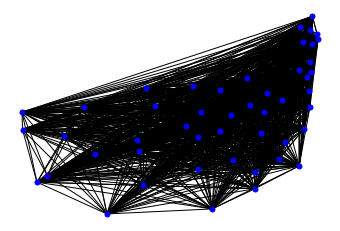

In [ ]:
tsp_graph = TSPGraph(0.1, 48, "att48.tsp")
tsp_graph.draw_graph(draw_edges = True)

In [ ]:
tsp_graph.edges[(0,1)]['pheromone'] = 0.2
tsp_graph.edges[(1,0)]['pheromone']

0.2

33523.0 <class 'float'>


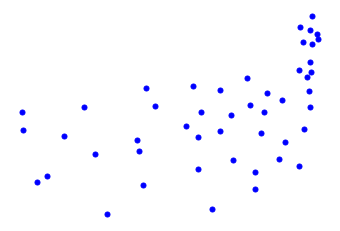

In [ ]:
tsp_graph = TSPGraph(0.1, 48, "att48.tsp")
tsp_graph.draw_graph(draw_edges = False)

### ACO for Travelling Salesman Problem

In [ ]:
class ACOTSP(AntColonyOptimizer):
  def __init__(self, graph, ants, alpha, beta, p, local_p = None, intensity = None, q_0 = None):
    """
    Ant colony optimizer for Path Planning.  
    Traverses a graph and finds the min weight distance 
    between a start and target node
    
    :param graph: graph environment
    :param ants:  number of ants to traverse the graph
    :param alpha: weighting of pheromone
    :param beta:  weighting of heuristic
    :param p:     evaporation rate at which pheromone evaporates
    :param local_p: local evaporation rate at which pheromone evaporates (optional)
    :param intensity: the amount of pheromones to add per edge (optional)
    :param q_0: probability to choose the best construction step (optional)
    """
    self.start_node = 0
    super().__init__(graph, ants, alpha, beta, p, local_p, intensity, q_0)

  def update_state(self):
    neighbors = self.graph[self.current_position]

    # Process to get the weight of each neighbor
    weights = []
    aux_weights = []
    neighbors_idx = []
    for neighbor_node, edge in neighbors.items():

      heuristic = 1 / edge['distance']

      if not self.is_visited(neighbor_node):
        # get the weight per neighbor and append it
        weights.append( (edge['pheromone'] ** self.alpha) * 
                      ( heuristic ** self.beta))
        aux_weights.append( edge['pheromone'] * 
                      (heuristic ** self.beta))
        neighbors_idx.append(neighbor_node)

    if len(weights) != 0:
      acu_weight = sum(weights)
      probabilities = np.array(weights)/acu_weight
      #print("[INFO] probabilities: {}".format(probabilities))

      # with probability q_0 select the best trial
      if self.q_0 is not None:
        if np.random.rand() < self.q_0:
          new_position = neighbors_idx[np.argmax(aux_weights)]
        else:
          # choose an option following the wheel selection algorithm  
          new_position = random.choices(neighbors_idx, weights = probabilities)[0]
      else:
        # choose an option following the wheel selection algorithm  
        new_position = random.choices(neighbors_idx, weights = probabilities)[0]

      # perform local evaporation
      if self.local_p is not None:
        self.local_evaporation(new_position)

      self.current_path.append((self.current_position, new_position))
      self.visited_nodes.append(new_position)
      self.current_position = new_position
    else:      
      self.current_path.append((self.current_position, self.start_node))
      self.visited_nodes.append(self.start_node)
      self.current_position =  self.start_node

  def end_route(self):
    return self.current_position == self.start_node

In [ ]:
# Define the parameters of our model
ants = 10
tau_0 = 1
alpha = 2. 
beta = 1.
p = 0.3
intensity = None

total_iter = 500
step_plot = 10

local_p = 0.4
q_0 = 0.3

33523.0 <class 'float'>


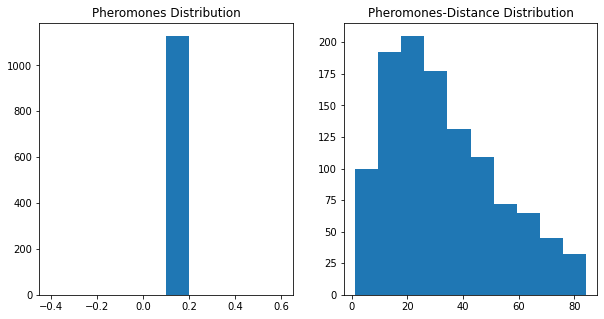

In [ ]:
# Create the graph
graph = TSPGraph(0.1, 48, "att48.tsp")

# Create the envioronment
optimizer = ACOTSP(graph, ants, alpha, beta, p, local_p, intensity, q_0)
#draw_grid(env)
display_pheromones(optimizer,10)

In [ ]:
list_distances = []
list_distances_avg = []

for iter in range(total_iter):

  distance_per_ants = []

  for ant in range(optimizer.ants):
    
    get_target = False
    while not get_target:
      optimizer.update_state()
      get_target = optimizer.end_route()
      
    optimizer.update_best_path()
    current_distance = optimizer.get_total_distance(optimizer.current_path)
    #print("[INFO] iter: {} ant: {} current: {}".format(iter, ant, current_distance))
    distance_per_ants.append(current_distance)
    optimizer.start_node = np.random.randint(0,48)
    optimizer.reset_environment()

  #optimizer.draw_grid()
  optimizer.offline_pheromone_update()

  # Track the best distance so far
  best_distance = optimizer.get_total_distance(optimizer.best_path)
  if iter % step_plot == 0:
    print("[INFO] iter: {} best: {} d_mean: {} d_stdv: {}".format(iter, 
                                                          best_distance, 
                                                          np.mean(distance_per_ants),
                                                          np.std(distance_per_ants)))
    #display_pheromones(env,10)
  list_distances.append(best_distance)
  list_distances_avg.append(np.mean(distance_per_ants))

[INFO] iter: 0 best: 72946.8709588917 d_mean: 88956.67004376012 d_stdv: 10966.828835766877
[INFO] iter: 10 best: 44768.824581247194 d_mean: 56679.71624998244 d_stdv: 6583.888108539997
[INFO] iter: 20 best: 41981.484837360505 d_mean: 53587.145472516655 d_stdv: 5951.260545374647
[INFO] iter: 30 best: 38476.87864480143 d_mean: 54413.54196180873 d_stdv: 7567.71074718774
[INFO] iter: 40 best: 38476.87864480143 d_mean: 56275.79551874193 d_stdv: 4929.408677903402
[INFO] iter: 50 best: 38476.87864480143 d_mean: 57950.888802805006 d_stdv: 5363.800274644261
[INFO] iter: 60 best: 38476.87864480143 d_mean: 56331.77684652495 d_stdv: 8436.233363641111
[INFO] iter: 70 best: 38476.87864480143 d_mean: 56922.30567429676 d_stdv: 6194.860357531522
[INFO] iter: 80 best: 38476.87864480143 d_mean: 52730.955792260844 d_stdv: 4818.932140872716
[INFO] iter: 90 best: 38476.87864480143 d_mean: 58963.326630168056 d_stdv: 6252.38631505985
[INFO] iter: 100 best: 38476.87864480143 d_mean: 54101.610792354986 d_stdv: 3

In [ ]:
#@title Function to plot the best distance per iteration
# plot the best distance per iteration
def plot_distance(list_distances, save = False, name2save = ""):

  list_iterations = np.arange(0, len(list_distances))
  #path_to_save = "stuff/figures/"
  #if not os.path.exists(path_to_save):
  #    os.mkdir(path_to_save)

  title = 'Average Distance vs Iterations'
  title += '\n ants: {} tau_0: {} alpha: {} beta: {} p: {}'.format(
      ants,
      tau_0,
      alpha,
      beta, 
      p
  )

  plt.title(title)
  plt.plot(list_iterations, list_distances, "b-") #, label = label)
  plt.legend()
  #if save: plt.savefig(os.path.join(path_to_save,name2save))

  plt.show()
  plt.close()

No handles with labels found to put in legend.


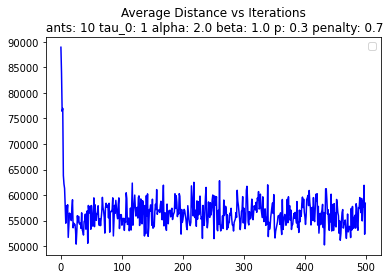

In [ ]:
plot_distance(list_distances_avg)

# Path Planning (Shortest Path)

First, we define the environment where the algorithm will take place. In this case, the environment is a weighted graph $G(N,E)$ with the the following characteristic:

1. The nodes are joined by equidistance edges, in a lattice form. 
2. Each edge have two weights the equal `distance` ($d=1$) and a `pheromone` value.
3. The nodes have different states, such as: `free`, `obstacle` or `target.`

In [4]:
# creating enumerations for status of a each node
# the number associated represent a mark to display
# the environment later in a grid mode
class State(enum.Enum):
    free = 0.9
    obstacle = 0.1
    target = 0.5

In [5]:
#@title Class to deffine the environment
class PPGraph(nx.Graph):
  def __init__(self, size, tau_0, filename = None):
    """Define a graph environment given a filename or a size, 
    and tau_0 (initial pheromone)
    """
    self.size = size
    self.tau_0 = tau_0
    nx.Graph.__init__(self) 
    self.__create_graph()

  def __create_graph(self):
    """Create a square lattice graph with size x size nodes.
    """

    self.clear() # Remove all the nodes and edges of the last graph
    current_node = 0
    for j in range(self.size - 1, -1, -1):
      for i in range(self.size):  

          #Adding neighbors to the current node
          self.__adding_edges(i,j,current_node, self.tau_0)

          #Adding the node to the network
          self.add_node(current_node, pos=(i,j), state = State.free) 
          current_node += 1

  def __adding_edges(self,i,j,current_node, tau_0):
    """Defines the neighbors per current node"""
    #There are four possible connection
    directions = {
        "up" : current_node - self.size,
        "down" : current_node + self.size,
        "left" : current_node - 1,
        "right" : current_node + 1
    }

    #For border cases of the network, we have to pop some connections
    if i == 0:
      directions.pop("left")
    if i == self.size - 1:
      directions.pop("right")
    if j == 0:
      directions.pop("down")
    if j == self.size - 1:
      directions.pop("up")

    for _, neighbor in directions.items():
      # adding edge      
      self.add_edge(current_node, neighbor, 
                    pheromone = tau_0, 
                    distance = 1)


  #Function to plot the structure of the graph
  def draw_graph(self, node_color='blue', node_size=25, with_labels=False):
    """
    Draw the graph.
        
    node_size: the size of all the nodes
    node_color: the color of all the nodes
    with_labels: True or False to show the ids of the nodes
    """
    fig, ax = plt.subplots()
    ax.set_aspect('equal') #set the x and y axes to the same scale
    pos = nx.get_node_attributes(self, 'pos')
    nx.draw(self, pos, node_color=node_color, node_size=node_size, with_labels=with_labels)


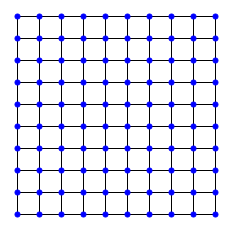

In [6]:
graph = PPGraph(size = 10, tau_0 = 0.1)
graph.draw_graph()

### Path Planng ACO (ACOPP)

In this version of the algorithm, we did few changes to deal with our problem.

1. `penalty`: A great prevalent problem in this algorithm is the capabality to avoid already visited nodes. In the TSP problem, we solve it only excluding these visited nodes. However, in this case, the algorithm tends to get stuck several times when we do so. This is mainly due to each node is not fully connected with all the other nodes. For this reason, we propose a `penalty` parameter, which reduces the pheromones (in a percent) of edges linked with already visited nodes. In this way, we avoid to fall in stuck condition whereas encourage to avoid already visited nodes

2. `proximity`: In this problem, use the heuristic $\eta_{ij}$ as `1 / distance` does not make sense due to all the edges have equal lengths. Thus, we considered a more informative metric, known as `proximity`. The `proximity` represent the **inverse relative distance of a neighbor node to the target node.** 

### Proximity and Multiplication Step

The `proximity` represent the inverse relative distance of a neighbor node to the target node. In this section, we review the distribution of this metric in environments with different sizes. Also, we propose a kind of **normalization step** to reduce the sparse values. The proximity of current node $i$ respect to the neighbor node $j$ is

$$ \mathrm{proximity1}_{ij} = \frac{1}{d_{jt}} = \eta_{ij} $$

where $d_{jt}$ is the manhattan or euclidean distance of the neighbor node $j$ to the target node $t$.

Additionally, here we propose to multiply the previous inverse distance to $d_{it}$, the distance of the current node $i$ to the target node $t$, as

$$ \mathrm{proximity2}_{ij} = \frac{d_{it}}{d_{jt}} = \eta_{ij} $$



In [3]:
def get_distance(pos1, pos2, distance):
  x1, y1 = pos1
  x2, y2 = pos2
  
  if distance == 'euclidean':
    result = np.sqrt((x2-x1)**2 + (y2-y1)**2)
  elif distance == 'manhattan':
    result = np.abs(x2-x1) + np.abs(y2-y1)

  return result

In [7]:
def get_proximity(graph, current_node, neighbor_node, target_node, 
                  mode = 'proximity_1', distance = 'euclidean'):
  """
  Proximity. Calculate the proximity of the neighbor node.
  :param graph:         graph environment
  :param current_node:  index of the current node i
  :param neighbor_node: index of the neihbor node j
  :param target_node:   index of the neihbor node t
  :param mode:          perform the proximity 1 or proximity 2
  :param distance:      used distance to calculate the proximity
  """
  pos_neighbor = graph.nodes[neighbor_node]['pos']
  pos_target = graph.nodes[target_node]['pos']
  pos_current = graph.nodes[current_node]['pos']

  # distance: current node to target
  dis_curr2target = get_distance(pos_current, pos_target, distance)
  
  # distance: neighbor to target
  dis_neig2target = get_distance(pos_neighbor, pos_target, distance)
  
  if neighbor_node == target_node:
    proximity = 1
  else:

    if mode == 'proximity_1':
      proximity = 1/ dis_neig2target
    elif mode == 'proximity_2':
      proximity = dis_curr2target / dis_neig2target

  return proximity

In [8]:
#@title Function: Calculate the proximities of the total environment
def get_env_proximities(graph, normalization = None, 
                        mode = 'proximity_1', distance = 'manhattan'):

  target_node = graph.size * graph.size - 1

  proximities_env = []

  for current_node in range(graph.number_of_nodes()):
    neighbors = graph[current_node]

    # print("Node: ", current_node)

    tmp_proximities = {}
    for neighbor_node, _ in neighbors.items():
        # get the weight per neighbor
        proximity = get_proximity(graph, 
                                     current_node,
                                     neighbor_node, 
                                     target_node,
                                     mode,
                                     distance)
        proximities_env.append(proximity)
        tmp_proximities[neighbor_node] = proximity
    # print("proximities: ", tmp_proximities)

  if normalization == 'standard':
    mean = np.mean(proximities_env)
    std = np.std(proximities_env)
    proximities_env = (proximities_env - mean) / std

  elif normalization == 'l2-norm':
    proximities_env = proximities_env / np.linalg.norm(proximities_env)

  return proximities_env

In [9]:
#@title Function: Plot Proximities Histograms
def plot_proximities(graph, bins, distance = 'manhattan'):

  inches = 5

  proximities_modes = ['proximity_1', 'proximity_2']
  normalization_modes = ['none', 'standard', 'l2-norm']

  fig, ax = plt.subplots(2,3, figsize = (15,10))

  for i in range(len(proximities_modes)):
    for j in range(len(normalization_modes)):

      proximities_env = get_env_proximities(graph, 
                                            normalization= normalization_modes[j], 
                                            mode = proximities_modes[i], 
                                            distance = distance)
      ax[i,j].hist(proximities_env, bins=bins)
      ax[i,j].set_title("Distribution: {} - {}".format(
          normalization_modes[j],
          proximities_modes[i]
      ))


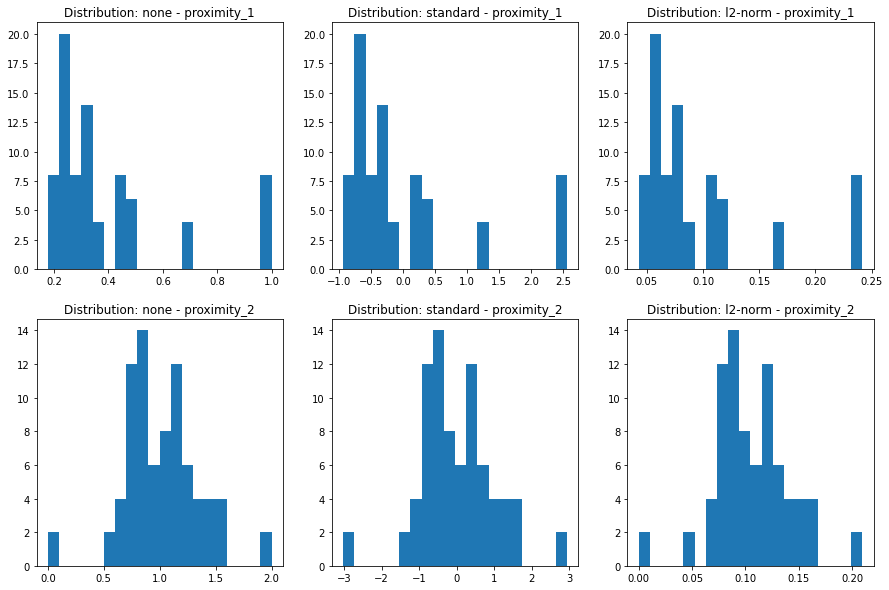

In [10]:
graph = PPGraph(size = 5, tau_0 = 0.1)
plot_proximities(graph, 20, distance='euclidean')

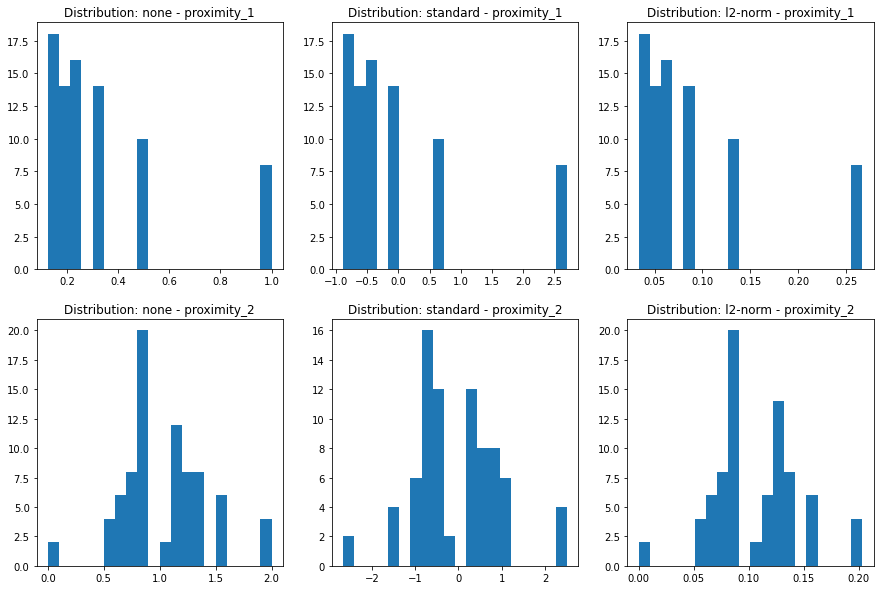

In [11]:
graph = PPGraph(size = 5, tau_0 = 0.1)
plot_proximities(graph, 20)

Now, we have the guidelines to the algorithm, here we define a class with all the process, inheriting the base `AntColonyOptimizer` class.

In [12]:
class ACOPP(AntColonyOptimizer):
  def __init__(self, graph, ants, alpha, beta, p, penalty, local_p = None, intensity = None, q_0 = None):
    """
    Ant colony optimizer for Path Planning.  
    Traverses a graph and finds the min weight distance 
    between a start and target node
    
    :param graph: graph environment
    :param ants:  number of ants to traverse the graph
    :param alpha: weighting of pheromone
    :param beta:  weighting of heuristic
    :param p:     evaporation rate at which pheromone evaporates
    :param local_p: local evaporation rate at which pheromone evaporates (optional)
    :param penalty: penalization percent of already visited nodes 
    :param intensity: the amount of pheromones to add per edge (optional)
    :param q_0: probability to choose the best construction step (optional)
    """    
    self.start_node = 0
    self.penalty = penalty
    self.size = graph.size
    self.target_node = self.size * self.size - 1

    super().__init__(graph, ants, alpha, beta, p, local_p, intensity, q_0)

    self.graph.nodes[self.graph.size * self.graph.size - 1]['state'] = State.target

  def update_state(self, mode = 'proximity_1', 
                   normalization = None,
                   mean = 0, 
                   std = 1, 
                   distance = 'euclidean'):
    neighbors = self.graph[self.current_position]

    # Process to get the weight of each neighbor
    weights = []
    aux_weights = []
    neighbors_idx = []
    for neighbor_node, edge in neighbors.items():
      proximity = get_proximity(self.graph, 
                                self.current_position,
                                neighbor_node,
                                self.target_node,
                                mode,
                                distance)
      if normalization is not None:
        proximity = (proximity - mean) / std      
    
      if not self.is_visited(neighbor_node):
        # get the weight per neighbor and append it
        weights.append( (edge['pheromone'] ** self.alpha) * 
                      (proximity ** self.beta))
        aux_weights.append( edge['pheromone'] * 
                      (proximity ** self.beta))
        neighbors_idx.append(neighbor_node)
      else:
        penalty_pheromone = (1 - self.penalty) * edge['pheromone']
        weights.append( (penalty_pheromone ** self.alpha) * 
              (proximity ** self.beta))
        aux_weights.append( penalty_pheromone * 
                      (proximity ** self.beta))
        neighbors_idx.append(neighbor_node)
    
    acu_weight = sum(weights)
    probabilities = np.array(weights)/acu_weight
    #print("[INFO] probabilities: {}".format(probabilities))

    # with probability q_0 select the best trial
    if self.q_0 is not None and np.random.rand() < self.q_0:
        new_position = neighbors_idx[np.argmax(aux_weights)]
    else:
      # choose an option following the wheel selection algorithm  
      new_position = random.choices(neighbors_idx, weights = probabilities)[0]

    # perform local evaporation
    if self.local_p is not None:
      self.local_evaporation(new_position)

    self.current_path.append((self.current_position, new_position))
    self.visited_nodes.append(new_position)
    self.current_position = new_position

  def end_route(self):
    return self.current_position == self.target_node

  def fit(self, total_iter):
    list_distances = []
    list_distances_avg = []
    list_distances_std = []

    for iter in range(total_iter):

      distance_per_ants = []

      for ant in range(self.ants):
        get_target = False
        while not get_target:
          self.update_state()
          get_target = self.end_route()
          
        self.update_best_path()
        current_distance = self.get_total_distance(self.current_path)
        #print("[INFO] iter: {} ant: {} current: {}".format(iter, ant, current_distance))
        distance_per_ants.append(current_distance)
        self.reset_environment()

      #optimizer.draw_grid()
      self.offline_pheromone_update()

      # Track the best distance so far
      best_distance = self.get_total_distance(self.best_path)
      if iter % step_plot == 0:
        print("[INFO] iter: {} best: {} d_mean: {} d_stdv: {}".format(iter, 
                                                              best_distance, 
                                                              np.mean(distance_per_ants),
                                                              np.std(distance_per_ants)))
        #display_pheromones(optimizer,10)
      list_distances.append(best_distance)
      list_distances_avg.append(np.mean(distance_per_ants))
      list_distances_std.append(np.std(distance_per_ants))

    history = {
        "distances_best" : list_distances,
        "distances_avg"  : list_distances_avg,
        "distances_std"  : list_distances_std
    }

    return history


Then, we defined some auxiliar functions to plot and check the behavior of the algorithm over time.

In [13]:
# Define the parameters of our model
ants = 10
tau_0 = 1
alpha = 3. 
beta = 2.
p = 0.3
intensity = None
local_p = 0
q_0 = 0.3

# Additional attributes
penalty = 0.7 # Nota el grado de penalización provoca que haya mas o menos ruido

total_iter = 200
step_plot = 10

In [15]:
# Create the graph
graph = PPGraph(size = 10, tau_0 = tau_0)
# Create the envioronment
optimizer = ACOPP(graph, ants, alpha, beta, p, penalty, local_p, intensity, q_0)
#draw_grid(optimizer)
#display_pheromones(optimizer,10)
history = optimizer.fit(total_iter)

[INFO] iter: 0 best: 20 d_mean: 25.4 d_stdv: 7.2691127381545
[INFO] iter: 10 best: 18 d_mean: 18.6 d_stdv: 1.8
[INFO] iter: 20 best: 18 d_mean: 18.2 d_stdv: 0.6
[INFO] iter: 30 best: 18 d_mean: 18.6 d_stdv: 1.2806248474865698
[INFO] iter: 40 best: 18 d_mean: 18.2 d_stdv: 0.6
[INFO] iter: 50 best: 18 d_mean: 18.4 d_stdv: 1.2
[INFO] iter: 60 best: 18 d_mean: 18.2 d_stdv: 0.6
[INFO] iter: 70 best: 18 d_mean: 18.6 d_stdv: 1.2806248474865698
[INFO] iter: 80 best: 18 d_mean: 19.2 d_stdv: 1.6
[INFO] iter: 90 best: 18 d_mean: 18.6 d_stdv: 1.2806248474865698
[INFO] iter: 100 best: 18 d_mean: 18.2 d_stdv: 0.6
[INFO] iter: 110 best: 18 d_mean: 20.8 d_stdv: 5.075431016179809
[INFO] iter: 120 best: 18 d_mean: 18.8 d_stdv: 1.5999999999999999
[INFO] iter: 130 best: 18 d_mean: 18.6 d_stdv: 1.8
[INFO] iter: 140 best: 18 d_mean: 18.2 d_stdv: 0.6
[INFO] iter: 150 best: 18 d_mean: 19.0 d_stdv: 2.4083189157584592
[INFO] iter: 160 best: 18 d_mean: 20.2 d_stdv: 4.331281565541543
[INFO] iter: 170 best: 18 d_m

In [16]:
#@title Function to check the construction of a path
def check_path_construction(optimizer, steps = 10):
  for i in range(steps):
    optimizer.update_state()
    print("pos: {:02d} \t path: {}".format(optimizer.current_position, optimizer.current_path))

In [18]:
#@title Function to display the histogram of pheromones
def display_pheromones(env, bins):
  #A = nx.attr_matrix(self.graph, edge_attr="pheromone", rc_order= np.arange(0,self.size * self.size))

  #print(A)
  edge_attributes = nx.get_edge_attributes(env.graph,'pheromone')

  pheromones = []
  phero_dist = []

  count = 0
  for _, _, attrib in env.graph.edges(data=True):
    pheromones.append(attrib['pheromone'])
    if attrib['pheromone'] == 0.1: count+=0

    phero_dist_val = (attrib['pheromone'] ** env.alpha) * (attrib['distance'] ** env.beta)
    phero_dist.append(phero_dist_val)

  fig, ax = plt.subplots(1,2, figsize = (10,5))
  ax[0].hist(pheromones, bins=bins)
  ax[0].set_title('Pheromones Distribution')

  ax[1].hist(phero_dist, bins=bins)
  ax[1].set_title('Pheromones-Distance Distribution')
  plt.show()

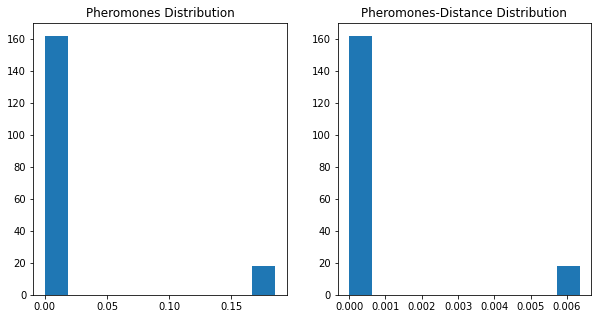

In [19]:
display_pheromones(optimizer,10)

In [20]:
#@title Function to plot the graph in a grid prespective
def draw_grid(base_class):
  # Create a canvas to display the visited cells, the ant, and the target
  # values: to traget, free cells, and obstacles
  canvas = [ state.value for _, state in nx.get_node_attributes(base_class.graph,'state').items() ]
  # values: to the visited cells
  for node in base_class.visited_nodes: canvas[node] = 0.2
  # values: to the ant
  canvas[base_class.current_position] = 0.3

  canvas = np.array(canvas).reshape((base_class.size, base_class.size))

  #Plot the maze
  fig, ax = plt.subplots(figsize=(base_class.size/2,base_class.size/2))
  ax.pcolor(canvas, edgecolors='k', cmap='Paired', linewidths=0.2, vmin = 0., vmax = 1.0)
  ax.set_aspect('equal') #set the x and y axes to the same scale
  plt.xticks(np.arange(0.5, base_class.size, step=1), labels=[i for i in range(base_class.size)]) 
  plt.yticks(np.arange(base_class.size - 0.5, 0, step=-1), labels=[i for i in range(base_class.size)])
  ax.invert_yaxis() #invert the y-axis so the first row of data is at the top

In [21]:
#@title Function to plot the best distance per iteration
# plot the best distance per iteration
def plot_distance(list_distances, save = False, name2save = ""):

  list_iterations = np.arange(0, len(list_distances))
  #path_to_save = "stuff/figures/"
  #if not os.path.exists(path_to_save):
  #    os.mkdir(path_to_save)

  title = 'Average Distance vs Iterations'
  title += '\n ants: {} tau_0: {} alpha: {} beta: {} p: {} penalty: {}'.format(
      ants,
      tau_0,
      alpha,
      beta, 
      p,
      penalty
  )

  plt.title(title)
  plt.plot(list_iterations, list_distances, "b-") #, label = label)
  plt.legend()
  #if save: plt.savefig(os.path.join(path_to_save,name2save))

  plt.show()
  plt.close()

No handles with labels found to put in legend.


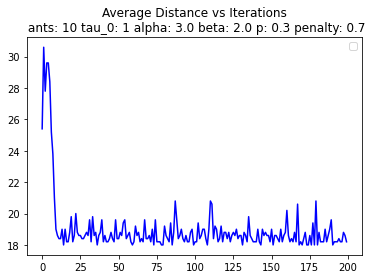

In [22]:
plot_distance(history['distances_avg'])

### Experiments

In section, we performed experiments varying some relevant parameters and keep constant the other ones.

#### Penalties Behavior

In [ ]:
# Varying penalty
ants = 10
tau_0 = 1
alpha = 3. 
beta = 2.
p = 0.3
intensity = None
local_p = None
q_0 = None

# Additional attributes
penalty_list = [0.3, 0.5, 0.7, 0.9] 

# Nota el grado de penalización provoca que haya mas o menos ruido
total_iter = 200
step_plot = 10

In [ ]:
histories = []
for penalty in penalty_list:
  # Create the graph
  graph = PPGraph(size = 10, tau_0 = tau_0)
  # Create the envioronment
  optimizer = ACOPP(graph, ants, alpha, beta, p, penalty, local_p, intensity, q_0)
  #draw_grid(optimizer)
  #display_pheromones(optimizer,10)
  history = optimizer.fit(total_iter)
  histories.append(history)

In [ ]:
#@title Function to plot the best distance per iteration
# plot the best distance per iteration
def plot_many_distances(histories, constant_params, var_name, variable_params, save = False, name2save = ""):

  list_iterations = np.arange(0, len(histories[0]['distances_avg']))


  title = 'Average Distance vs Iterations \n'
  for k, v in constant_params.items():
    title += "{}: {} ".format(k, v)
  figure(figsize=(10, 5), dpi=80)
  plt.title(title)
  
  min = np.amin(histories[0]['distances_best'])
  for param, history in zip(variable_params, histories):
    label = str(param)
    plt.plot(list_iterations, history['distances_avg'], "-", label = label)
    plt.fill_between(list_iterations, 
                     np.clip(np.array(history['distances_avg']) - np.array(history['distances_std']),min,float('inf')), 
                     np.array(history['distances_avg']) + np.array(history['distances_std']), 
                     alpha=0.2)
  plt.legend(title=var_name)
  #if save: plt.savefig(os.path.join(path_to_save,name2save))

  plt.show()
  plt.close()

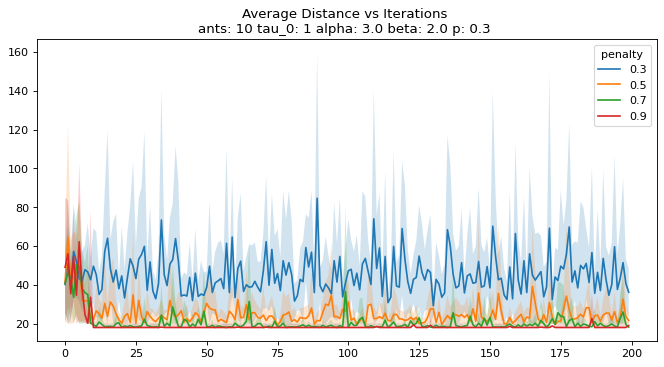

In [ ]:
constant_params = {
    "ants": ants ,
    "tau_0": tau_0,
    "alpha": alpha,
    "beta": beta,
    "p": p
}
plot_many_distances(histories[-4:],constant_params, "penalty", penalty_list[-4:])

#### Local Pheromone Evaporation Variation

In [ ]:
# Varying penalty
ants = 10
tau_0 = 1
alpha = 3. 
beta = 2.
p = 0.3
intensity = None
local_p_list = [0.3, 0.5, 0.7, 0.9]
q_0 = None

# Additional attributes
penalty = 0.5

# Nota el grado de penalización provoca que haya mas o menos ruido
total_iter = 200
step_plot = 10

In [ ]:
histories = []
for local_p in local_p_list:
  # Create the graph
  graph = PPGraph(size = 10, tau_0 = tau_0)
  # Create the envioronment
  optimizer = ACOPP(graph, ants, alpha, beta, p, penalty, local_p, intensity, q_0)
  #draw_grid(optimizer)
  #display_pheromones(optimizer,10)
  history = optimizer.fit(total_iter)
  histories.append(history)

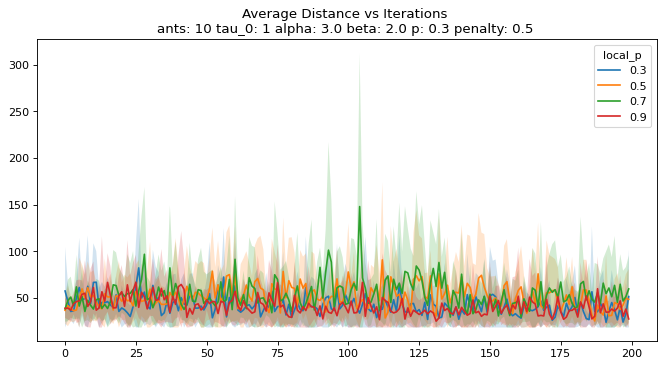

In [ ]:
constant_params = {
    "ants": ants ,
    "tau_0": tau_0,
    "alpha": alpha,
    "beta": beta,
    "p": p,
    "penalty" : penalty
}
plot_many_distances(histories[-4:], constant_params, "local_p", local_p_list[-4:])

#### q_0 Parameter Variation

In [ ]:
ants = 10
tau_0 = 1
alpha = 3. 
beta = 2.
p = 0.3
intensity = None
local_p = 0.3
q_0_list = [0.3, 0.5, 0.7, 0.9]

# Additional attributes
penalty = 0.5

# Nota el grado de penalización provoca que haya mas o menos ruido
total_iter = 200
step_plot = 10

In [ ]:
histories = []
for q_0 in q_0_list:
  # Create the graph
  graph = PPGraph(size = 10, tau_0 = tau_0)
  # Create the envioronment
  optimizer = ACOPP(graph, ants, alpha, beta, p, penalty, local_p, intensity, q_0)
  #draw_grid(optimizer)
  #display_pheromones(optimizer,10)
  history = optimizer.fit(total_iter)
  histories.append(history)

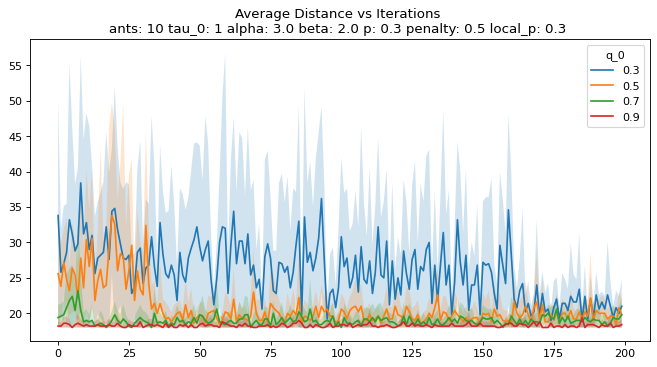

In [ ]:
constant_params = {
    "ants": ants ,
    "tau_0": tau_0,
    "alpha": alpha,
    "beta": beta,
    "p": p,
    "penalty" : penalty,
    "local_p" : local_p
}
plot_many_distances(histories[-4:], constant_params, "q_0", q_0_list[-4:])

In [ ]:
ants = 10
tau_0 = 1
alpha = 3. 
beta = 2.
p = 0.3
intensity = None
local_p = 0.7
q_0_list = [0.3, 0.5, 0.7, 0.9]

# Additional attributes
penalty = 0.5

# Nota el grado de penalización provoca que haya mas o menos ruido
total_iter = 200
step_plot = 10

In [ ]:
histories = []
for q_0 in q_0_list:
  # Create the graph
  graph = PPGraph(size = 10, tau_0 = tau_0)
  # Create the envioronment
  optimizer = ACOPP(graph, ants, alpha, beta, p, penalty, local_p, intensity, q_0)
  #draw_grid(optimizer)
  #display_pheromones(optimizer,10)
  history = optimizer.fit(total_iter)
  histories.append(history)

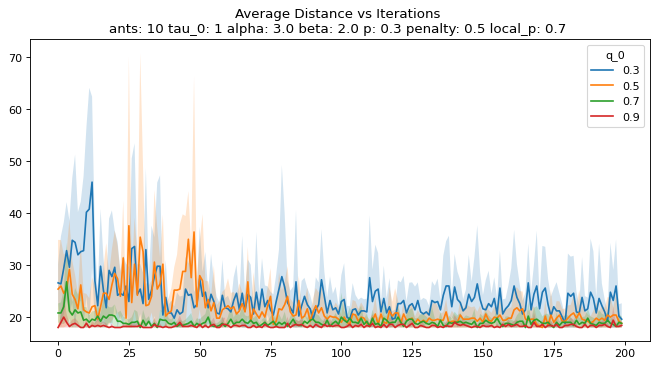

In [ ]:
constant_params = {
    "ants": ants ,
    "tau_0": tau_0,
    "alpha": alpha,
    "beta": beta,
    "p": p,
    "penalty" : penalty,
    "local_p" : local_p
}
plot_many_distances(histories[-4:], constant_params, "q_0", q_0_list[-4:])

In [ ]:
ants = 10
tau_0 = 1
alpha = 3. 
beta = 2.
p = 0.3
intensity = None
local_p = 0.3
q_0_list = [0.3, 0.5, 0.7, 0.9]

# Additional attributes
penalty = 0.3

# Nota el grado de penalización provoca que haya mas o menos ruido
total_iter = 200
step_plot = 10

In [ ]:
histories = []
for q_0 in q_0_list:
  # Create the graph
  graph = PPGraph(size = 10, tau_0 = tau_0)
  # Create the envioronment
  optimizer = ACOPP(graph, ants, alpha, beta, p, penalty, local_p, intensity, q_0)
  #draw_grid(optimizer)
  #display_pheromones(optimizer,10)
  history = optimizer.fit(total_iter)
  histories.append(history)

[INFO] iter: 0 best: 24 d_mean: 29.2 d_stdv: 4.308131845707604
[INFO] iter: 10 best: 18 d_mean: 26.8 d_stdv: 5.81033561853358
[INFO] iter: 20 best: 18 d_mean: 27.6 d_stdv: 8.662563131083086
[INFO] iter: 30 best: 18 d_mean: 30.2 d_stdv: 10.371113729971338
[INFO] iter: 40 best: 18 d_mean: 29.4 d_stdv: 7.045565981523415
[INFO] iter: 50 best: 18 d_mean: 33.8 d_stdv: 9.271461589199408
[INFO] iter: 60 best: 18 d_mean: 36.0 d_stdv: 13.053735097664577
[INFO] iter: 70 best: 18 d_mean: 30.8 d_stdv: 4.995998398718719
[INFO] iter: 80 best: 18 d_mean: 28.6 d_stdv: 11.421033228215387
[INFO] iter: 90 best: 18 d_mean: 36.6 d_stdv: 21.799999999999997
[INFO] iter: 100 best: 18 d_mean: 26.4 d_stdv: 3.9799497484264794
[INFO] iter: 110 best: 18 d_mean: 37.8 d_stdv: 19.727138667328315
[INFO] iter: 120 best: 18 d_mean: 38.2 d_stdv: 19.502820308868152
[INFO] iter: 130 best: 18 d_mean: 31.8 d_stdv: 15.42595215861893
[INFO] iter: 140 best: 18 d_mean: 28.2 d_stdv: 9.526804291051644
[INFO] iter: 150 best: 18 d_me

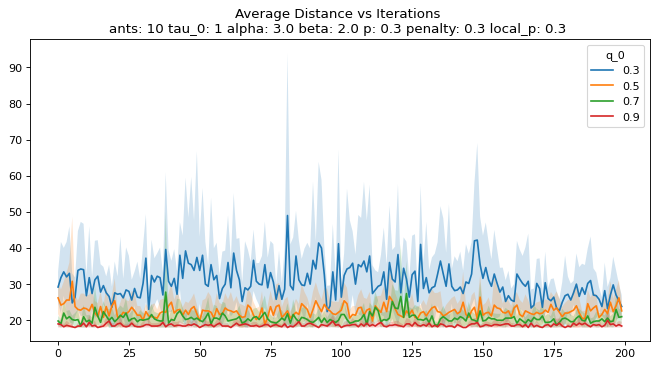

In [ ]:
constant_params = {
    "ants": ants ,
    "tau_0": tau_0,
    "alpha": alpha,
    "beta": beta,
    "p": p,
    "penalty" : penalty,
    "local_p" : local_p
}
plot_many_distances(histories[-4:], constant_params, "q_0", q_0_list[-4:])

# Walker class

random walk with tendency

In [23]:
class Walker():
  def __init__(self, graph, q_0 = None, reward_tau = 0.0001):
    
  
    self.graph = graph
    self.q_0 = q_0
    self.size = graph.size
    self.start_node = 0
    self.target_node = graph.size * graph.size - 1
    self.reset_walk()

  def reset_walk(self):
    self.current_path = []
    self.current_position = self.start_node
    self.visited_nodes = []

  def update_step(self, proximity_mode = 'proximity_1', 
                  distance_type = 'euclidean',
                  normalization = None):
    neighbors = self.graph[self.current_position]

    weights = []
    neighbors_idx = []
    for neighbor_node, edge in neighbors.items():
        # get the weight per neighbor
        weights.append(get_proximity(self.graph, 
                                     self.current_position,
                                     neighbor_node, 
                                     self.target_node,
                                     proximity_mode,
                                     distance_type))
        neighbors_idx.append(neighbor_node)

    if normalization == 'l2-norm':
      weights = np.array(weights) / np.linalg.norm(weights)
    elif normalization == 'standard':
      mean = np.mean(weights)
      std = np.std(weights)
      weights = ( np.array(weights) - mean) / std

    if self.q_0 is not None and np.random.rand() < self.q_0:
      new_position = neighbors_idx[np.argmax(weights)]
  
    else:
      acu_weight = sum(weights)
      probabilities = np.array(weights)/acu_weight
      #print("[INFO] probabilities: {}".format(probabilities))

      # choose an option following the wheel selection algorithm  
      new_position = random.choices(neighbors_idx, weights = probabilities)[0]
      
    self.current_path.append((self.current_position, new_position))
    self.visited_nodes.append(new_position)
    self.current_position = new_position

  def end_route(self):
    return self.current_position == self.target_node


  def walk(self, num_rand_walks, 
           proximity_mode = 'proximity_1', 
           distance_type = 'euclidean',
           normalization = None):
    # Create
    distances_list = []

    for i in range(int(num_rand_walks)):
      
      is_complete = False

      while not is_complete:
        self.update_step(proximity_mode = proximity_mode,
                         distance_type = distance_type,
                         normalization = normalization)

        is_complete = self.end_route()

      #print("[INFO] n_rw: {} len_path: {}".format(i, len(walker.current_path) ))
      distances_list.append(len(self.current_path))

      self.reset_walk()

    return distances_list

In [24]:
proximities_options = ['proximity_1', 'proximity_2']
distances_options = ['euclidean', 'manhattan']
normalization_options = [ 'none', 'l2-norm']
num_rand_walks = 1e5
q_0 = 0.3

mul_distances_list = {}

for proximity in proximities_options:

  tmp_dic = {}

  for distance in distances_options:

    tmp2_dic = {}

    for normalization in normalization_options:
      # Create the graph
      graph = PPGraph(size = 10, tau_0 = 0.1)

      # Create the walker
      walker = Walker(graph, reward_tau = 0.0001)

      # Perform the walk
      distances_list = walker.walk(num_rand_walks= num_rand_walks,
                                  proximity_mode = proximity,
                                  distance_type = distance,
                                  normalization = normalization)
      print("Proximity: {} Distance: {} Normalization: {} Mean: {} Std: {}".format(
          proximity,
          distance,
          normalization,
          np.mean(distances_list),
          np.std(distances_list)))
      
      tmp2_dic[normalization] = distances_list

    tmp_dic[distance] = tmp2_dic
  mul_distances_list[proximity] = tmp_dic

KeyboardInterrupt: ignored

NOTA: T-student, buscar como puedo comprobar que dos distribuciones de datos son diferentes

[stats models](https://www.statsmodels.org/stable/index.html)

plotear las medias y desviaciones standar de diferentes q_0

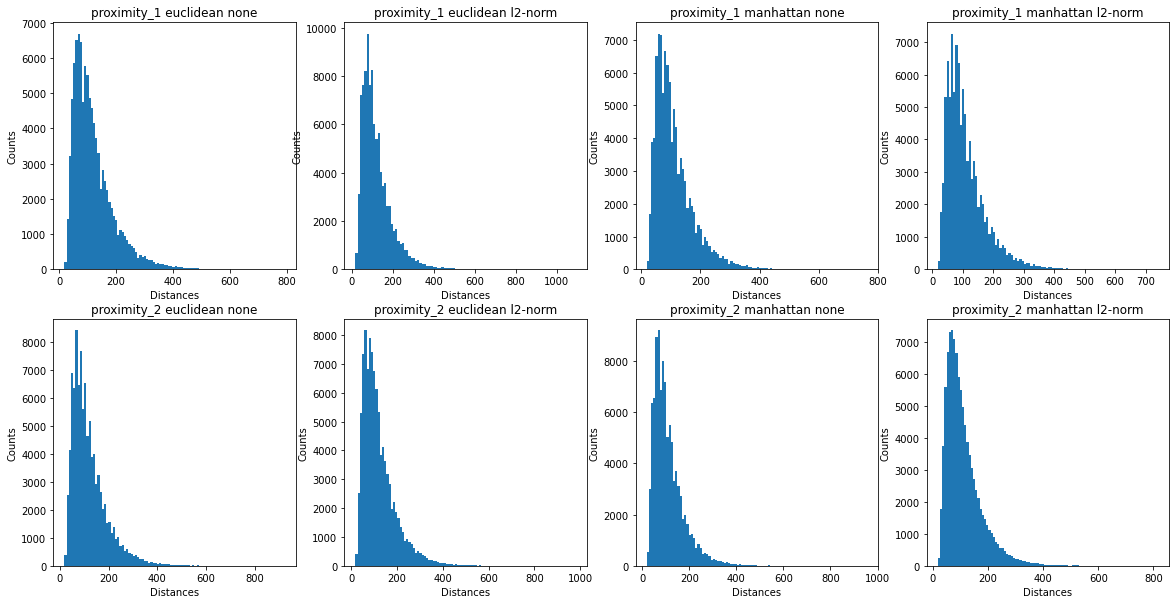

In [ ]:
rows = len(proximities_options)
cols = len(distances_options) * len(normalization_options)
inches = 5
fig, axs = plt.subplots(rows, cols , figsize = (cols * inches, rows * inches))

for i, proximity in enumerate(proximities_options):
  j = 0
  for distance in distances_options:
    for normalization in normalization_options:
      axs[i,j].hist(mul_distances_list[proximity][distance][normalization], bins=100)
      axs[i,j].set_xlabel ("Distances")
      axs[i,j].set_ylabel("Counts")
      #title = "Random Walk Distances Distribution\n"
      title = "{} {} {}".format(proximity,distance, normalization)
      axs[i,j].set_title(title)
      j += 1

In [ ]:
q_0_options = [0.3, 0.5, 0.7, 0.9]
proximity_type = "proximity_2"
distance_type = "manhattan"

def plot_distribution_q_0(q_0_options, proximity_type, distance_type):
  rows = 1
  cols = len(q_0_options)
  inches = 5
  fig, axs = plt.subplots(rows, cols) #, figsize = (cols * inches, rows * inches))

  for i, q_0 in enumerate(q_0_options):
    # Create the graph
    graph = PPGraph(size = 10, tau_0 = 0.1)

    # Create the walker
    walker = Walker(graph, reward_tau = 0.0001, q_0 = q_0)

    # Perform the walk
    distances_list = walker.walk(num_rand_walks= 1e5,
                                proximity_mode = proximity_type,
                                distance_type =  distance_type,
                                normalization = None)
    print("Proximity: {} Distance: {} Normalization: {} Mean: {} Std: {}".format(
        proximity,
        distance,
        normalization,
        np.mean(distances_list),
        np.std(distances_list)))
    
    axs[i].hist(distances_list, bins=100)
    axs[i].set_xlabel ("Distances")
    axs[i].set_ylabel("Counts")
    #title = "Random Walk Distances Distribution\n"
    title = "{} {} {} q_0: {}".format(proximity_type, distance_type, normalization, q_0)
    axs[i].set_title(title)
    

Proximity: proximity_2 Distance: manhattan Normalization: l2-norm Mean: 43.03222 Std: 14.521550945804654
Proximity: proximity_2 Distance: manhattan Normalization: l2-norm Mean: 30.5996 Std: 7.714842826655642
Proximity: proximity_2 Distance: manhattan Normalization: l2-norm Mean: 23.8375 Std: 4.261656221470709
Proximity: proximity_2 Distance: manhattan Normalization: l2-norm Mean: 19.58768 Std: 1.9055687386184732


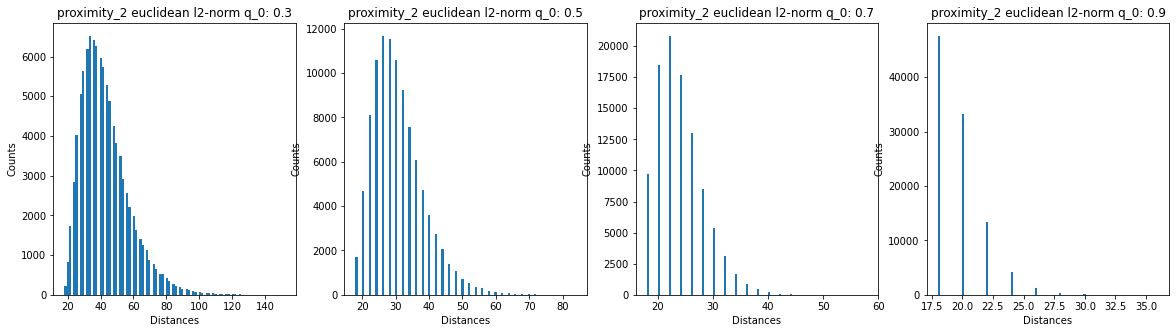

In [ ]:
q_0_options = [0.3, 0.5, 0.7, 0.9]
proximity_type = "proximity_2"
distance_type = "euclidean"

rows = 1
cols = len(q_0_options)
inches = 5
fig, axs = plt.subplots(rows, cols , figsize = (cols * inches, rows * inches))

for i, q_0 in enumerate(q_0_options):
  # Create the graph
  graph = PPGraph(size = 10, tau_0 = 0.1)

  # Create the walker
  walker = Walker(graph, reward_tau = 0.0001, q_0 = q_0)

  # Perform the walk
  distances_list = walker.walk(num_rand_walks= 1e5,
                              proximity_mode = proximity_type,
                              distance_type =  distance_type,
                              normalization = None)
  print("Proximity: {} Distance: {} Normalization: {} Mean: {} Std: {}".format(
      proximity,
      distance,
      normalization,
      np.mean(distances_list),
      np.std(distances_list)))
  
  axs[i].hist(distances_list, bins=100)
  axs[i].set_xlabel ("Distances")
  axs[i].set_ylabel("Counts")
  #title = "Random Walk Distances Distribution\n"
  title = "{} {} {} q_0: {}".format(proximity_type, distance_type, normalization, q_0)
  axs[i].set_title(title)
  

In [ ]:
arr = [1, 3, 2, 2]
winner = np.argwhere(arr == np.amax(arr))

np.random.choice(winner.flatten(), 1)[0]

1

In [ ]:
class WalkerLeftBottom(Walker):
  def __init__(self, graph, q_0 = None, reward_tau = 0.0001):

    super().__init__(graph, q_0, reward_tau)

  def get_left_right(self):
    return [self.current_position + 1, self.current_position + self.size]

  def update_step(self, advantage = 3):
    neighbors = self.graph[self.current_position]

    neighbors_idx = [n for n, edge in neighbors.items()]
    l_r = self.get_left_right()
    weights = [ advantage if n in l_r else 1 for n in neighbors_idx ]


    if self.q_0 is not None and np.random.rand() < self.q_0:
      new_position = neighbors_idx[np.argmax(weights)]
      # arg_max = np.argwhere(weights == np.amax(weights))
      # new_position = np.random.choice(arg_max.flatten(), 1)[0]
  
    else:
      acu_weight = sum(weights)
      probabilities = np.array(weights)/acu_weight
      # print("[INFO] curren_node: {} nodes: \t {}".format(self.current_position, neighbors_idx))
      # print("[INFO] probabilities: \t {}".format(probabilities))

      # choose an option following the wheel selection algorithm 
      new_position = random.choices(neighbors_idx, weights = probabilities)[0]
      
    self.current_path.append((self.current_position, new_position))
    self.visited_nodes.append(new_position)
    self.current_position = new_position

  def walk(self, num_rand_walks, advantage = 3):
    # Create
    distances_list = []

    for i in range(int(num_rand_walks)):
      
      is_complete = False

      while not is_complete:
        self.update_step(advantage)

        is_complete = self.end_route()

      #print("[INFO] n_rw: {} len_path: {}".format(i, len(walker.current_path) ))
      distances_list.append(len(self.current_path))

      self.reset_walk()

    return distances_list

In [ ]:
def plot_distribution_q_0(q_0_options, num_rand_walks):
  rows = 1
  cols = len(q_0_options)
  inches = 5
  fig, axs = plt.subplots(rows, cols, figsize = (cols * inches, rows * inches))

  for i, q_0 in enumerate(q_0_options):
    # Create the graph
    graph = PPGraph(size = 10, tau_0 = 0.1)

    # Create the walker
    walker = WalkerLeftBottom(graph, reward_tau = 0.0001, q_0 = q_0)

    # Perform the walk
    distances_list = walker.walk(num_rand_walks= num_rand_walks, advantage = 2)
    print("RightBottom - Mean: {} Std: {}".format(
        np.mean(distances_list),
        np.std(distances_list)))
    
    axs[i].hist(distances_list, bins=100)
    axs[i].set_xlabel ("Distances")
    axs[i].set_ylabel("Counts")
    #title = "Random Walk Distances Distribution\n"
    title = "{} q_0: {}".format("LeftRight", q_0)
    axs[i].set_title(title)
    

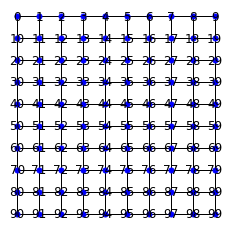

In [ ]:
graph = PPGraph(10, 1)
graph.draw_graph(with_labels=True)

LeftRight - Mean: 59.05012 Std: 25.74178175623436
LeftRight - Mean: 35.90736 Std: 10.78053699174582
LeftRight - Mean: 28.0794 Std: 6.466202567195062
LeftRight - Mean: 22.8669 Std: 3.777645349950151
LeftRight - Mean: 19.32122 Std: 1.7271993838581576


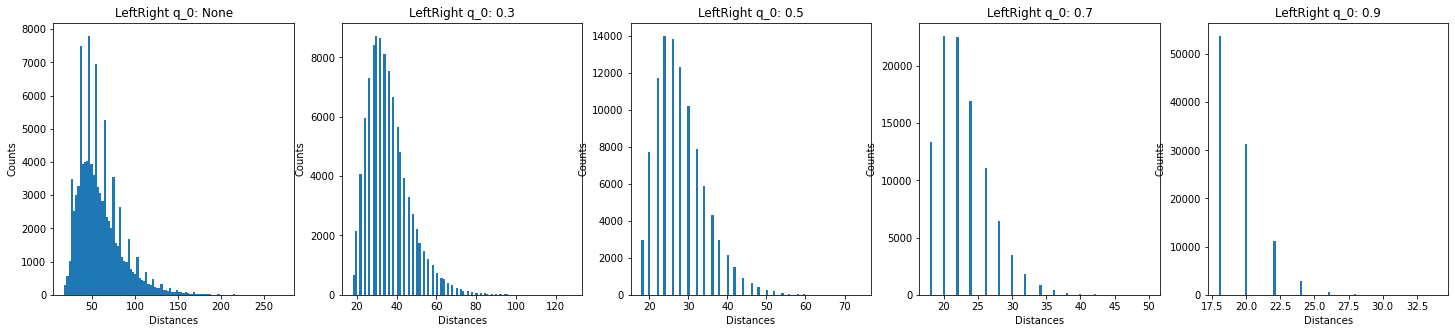

In [ ]:
q_0_options = [None, 0.3, 0.5, 0.7, 0.9]

plot_distribution_q_0(q_0_options, num_rand_walks = 1e5)


In [ ]:
class WalkerLevyFlightLB(Walker):
  def __init__(self, graph, q_0 = None, omega = 2, reward_tau = 0.0001):
    # omega clustering exponent

    self.omega = omega

    super().__init__(graph, q_0, reward_tau)

  def get_left_right(self):
    return [self.current_position + 1, self.current_position + self.size]

  def update_step(self, advantage = 3):
    neighbors = self.graph[self.current_position]

    neighbors_idx = [n for n, edge in neighbors.items()]

    # the possible long_range connection are all except the neighbors
    # or the start and target nodes
    pos_connections = [ n if n not in neighbors_idx for n in np.arange(self.start_node + 1, self.target_node)]

    long_range_node = random.choices(pos_connections)[0]

    dist_current2long_range = get_distance(self.graph.nodes[long_range_node]['pos'],
                                           self.graph.nodes[self.current_position]['pos'])

    if np.random.rand() < dist_current2long_range ** (- self.omega):
      new_position = long_range_node
    else:
      l_r = self.get_left_right()
      weights = [ advantage if n in l_r else 1 for n in neighbors_idx ]


      if self.q_0 is not None and np.random.rand() < self.q_0:
        new_position = neighbors_idx[np.argmax(weights)]
        # arg_max = np.argwhere(weights == np.amax(weights))
        # new_position = np.random.choice(arg_max.flatten(), 1)[0]
    
      else:
        acu_weight = sum(weights)
        probabilities = np.array(weights)/acu_weight
        # print("[INFO] curren_node: {} nodes: \t {}".format(self.current_position, neighbors_idx))
        # print("[INFO] probabilities: \t {}".format(probabilities))

        # choose an option following the wheel selection algorithm 
        new_position = random.choices(neighbors_idx, weights = probabilities)[0]
      
    self.current_path.append((self.current_position, new_position))
    self.visited_nodes.append(new_position)
    self.current_position = new_position

  def walk(self, num_rand_walks, advantage = 3):
    # Create
    distances_list = []

    for i in range(int(num_rand_walks)):
      
      is_complete = False

      while not is_complete:
        self.update_step(advantage)

        is_complete = self.end_route()

      #print("[INFO] n_rw: {} len_path: {}".format(i, len(walker.current_path) ))
      distances_list.append(len(self.current_path))

      self.reset_walk()

    return distances_list

In [ ]:
class WalkerLevyFlightLB(Walker):
  def __init__(self, graph, q_0 = None, omega = 2, reward_tau = 0.0001):
    # omega clustering exponent

    self.omega = omega

    super().__init__(graph, q_0, reward_tau)

  def get_left_right(self):
    return [self.current_position + 1, self.current_position + self.size]

  def update_step(self, advantage = 3):
    neighbors = self.graph[self.current_position]

    neighbors_idx = [n for n, edge in neighbors.items()]

    # the possible long_range connection are all except the neighbors
    # or the start and target nodes
    pos_connections = [ n if n not in neighbors_idx for n in np.arange(self.start_node + 1, self.target_node)]

    long_range_node = random.choices(pos_connections)[0]

    dist_current2long_range = get_distance(self.graph.nodes[long_range_node]['pos'],
                                           self.graph.nodes[self.current_position]['pos'])

    if np.random.rand() < dist_current2long_range ** (- self.omega):
      new_position = long_range_node
    else:
      l_r = self.get_left_right()
      weights = [ advantage if n in l_r else 1 for n in neighbors_idx ]


      if self.q_0 is not None and np.random.rand() < self.q_0:
        new_position = neighbors_idx[np.argmax(weights)]
        # arg_max = np.argwhere(weights == np.amax(weights))
        # new_position = np.random.choice(arg_max.flatten(), 1)[0]
    
      else:
        acu_weight = sum(weights)
        probabilities = np.array(weights)/acu_weight
        # print("[INFO] curren_node: {} nodes: \t {}".format(self.current_position, neighbors_idx))
        # print("[INFO] probabilities: \t {}".format(probabilities))

        # choose an option following the wheel selection algorithm 
        new_position = random.choices(neighbors_idx, weights = probabilities)[0]
      
    self.current_path.append((self.current_position, new_position))
    self.visited_nodes.append(new_position)
    self.current_position = new_position

  def walk(self, num_rand_walks, advantage = 3):
    # Create
    distances_list = []

    for i in range(int(num_rand_walks)):
      
      is_complete = False

      while not is_complete:
        self.update_step(advantage)

        is_complete = self.end_route()

      #print("[INFO] n_rw: {} len_path: {}".format(i, len(walker.current_path) ))
      distances_list.append(len(self.current_path))

      self.reset_walk()

    return distances_list

Uno de los problemas sobresalientes en problemas de decision es la cantidad de estados presentes y las posibles acciones. Cuando este numero empieza a subir mucho, los algoritmos empiezan a subir problemas [consultar]. Es una area muy estudiada ttatatatat . En el presente paper se pretende estudiar este comportamiento mediante una aplicacion muestra o un escenario de juguete en donde se puede compreder de manera experimental la difficultad de alcanzar valores optimos cuando el numero de estados crece y las acciones posibles se limitan. En este caso particular se utilizo un ACO para demostrar nuestra hypothesis, que puede ser considerado a breves rasgos como un RL algorimo por su esencia de refuerzo y tal tal. Sin embargo, se pretende que sea el pilas esencial para un investigacion mas profunda de este estilo.  

1. Uno de los problemas con este tipo de algoritmos parece ser la cantidad de estados que empieza a elevarse. En un ambiente libre de obstaculos resulta sencillo resolver el problema. Sin embargo a medida que se aumentan los estados y los obstaculos presentes en el ambiente el algoritmo empieza a fallar. Existen ciertas metodo que resuelven el problema desde diferentes escenarios como algoritmos por REFUERZO, .. .. .. . En este paper, la idea es implementar cierta inicializacion de fermonas con el objetivo de superar este problema. Aunque el paper abordara un problema de combinacion bastante fundamental. El paper pretende servir como un fundamento para emplear estas mismas ideas en escenarios más complejos.

Hipotesis: proveer al algoritmo de cierto informacion (conocimiento) inicial por medio de la inicialización de fermonos siguiendo random walks. De cierta manera se espera que los random walks logren lidiar con el problema de estados y obstaculos y a su vez mejorar los tiempos de convergencia de los escenerios ya estudiados.

En general, el presente proyecto intenta abordar el problema de planificacion de ruta o path finding. Sin embargo, se podria escalar la inicializacion por random walks a escenarios más complejos e incluso a otros enfoques como algoritmos de reinforcement learning cuya esencia es optimizar la recompensa futura in a long term. Esta en escencia relacionado al algoritmo ACO por el refuerzo que recibe de las fermonos. Sin embargo, RL algoritmos implementan algoritmos más robustos.

Estudiarlo con algoritmos de refuerzo mas actuales, mas robustos donde exista cierta información suycente (como las fermonas en este caso) que aceleren el aprendizaje. Sin embargo, no necesariamente se buscaria alterar las recompensas en dichos algoritmos, ya que su actualización romperia la esencia de un algoritmo por refuerzo.